<a href="https://colab.research.google.com/github/nbilasals/diabetes_pred_stacking/blob/main/diabetes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# CONNECT GOOGLE DRIVE
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import warnings 
warnings.filterwarnings('ignore')

In [7]:
df = pd.read_csv("/content/drive/My Drive/dataset/project/diabetes_classification/diabetes.csv")
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [12]:
col_summary = pd.DataFrame(df.columns, columns = ['Column'])
na_list = []
unique_list = []
dtype_list = []

for col in df.columns:
    na_list.append(df[col].isna().sum())
    unique_list.append(df[col].nunique())
    dtype_list.append(df[col].dtype)
    
col_summary['Missing values'] = na_list
col_summary['Unique values'] = unique_list
col_summary['Data type'] = dtype_list
col_summary

,Column,Missing values,Unique values,Data type
0,Pregnancies,0,17,int64
1,Glucose,0,136,int64
2,BloodPressure,0,47,int64
3,SkinThickness,0,51,int64
4,Insulin,0,186,int64
5,BMI,0,248,float64
6,DiabetesPedigreeFunction,0,517,float64
7,Age,0,52,int64
8,Outcome,0,2,int64


0    453
1    221
Name: Outcome, dtype: int64


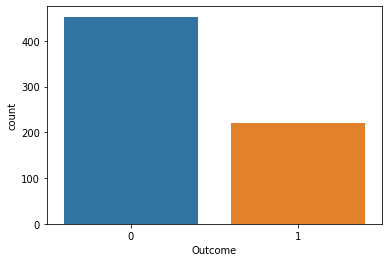

In [29]:
print(df['Outcome'].value_counts())
sns.countplot(x='Outcome',data=df)

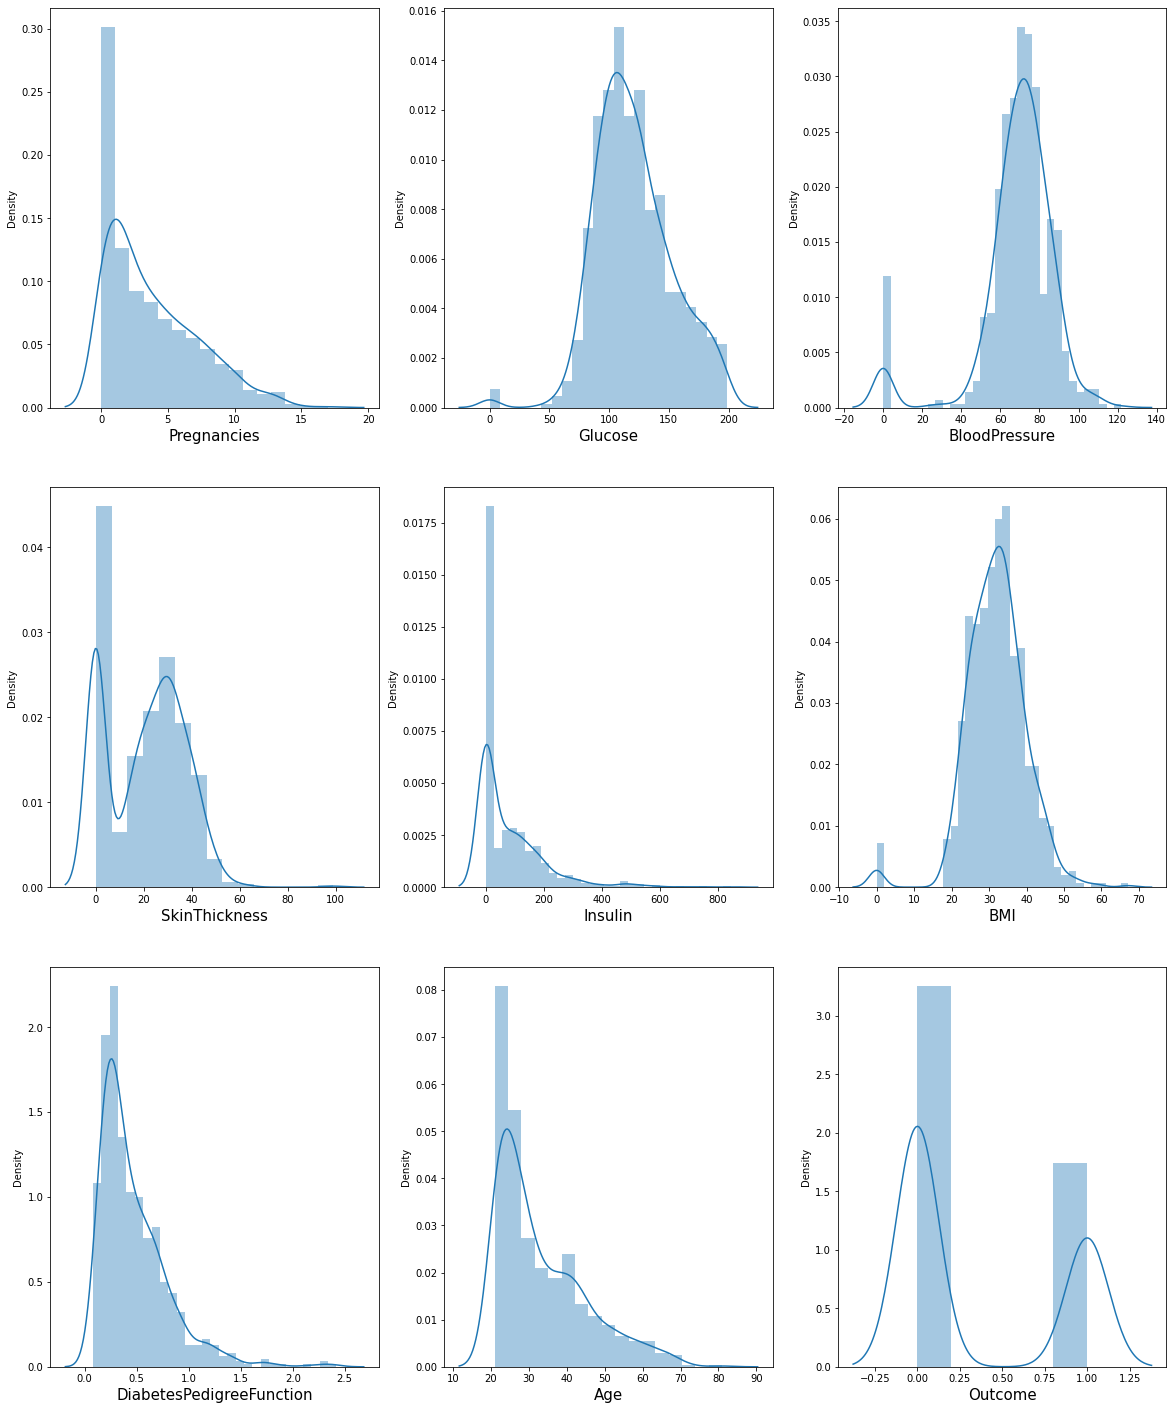

In [15]:
# let's see how data is distributed for every column.

plt.figure(figsize = (20, 25))
plotnumber = 1

for column in df:
    if plotnumber <= 9:
        ax = plt.subplot(3, 3, plotnumber)
        sns.distplot(df[column])
        plt.xlabel(column, fontsize = 15)
        
    plotnumber += 1
plt.show()

In [16]:
# replacing zero values with the mean of the columnn

df['BMI'] = df['BMI'].replace(0, df['BMI'].mean())
df['BloodPressure'] = df['BloodPressure'].replace(0, df['BloodPressure'].mean())
df['Glucose'] = df['Glucose'].replace(0, df['Glucose'].mean())
df['Insulin'] = df['Insulin'].replace(0, df['Insulin'].mean())
df['SkinThickness'] = df['SkinThickness'].replace(0, df['SkinThickness'].mean())

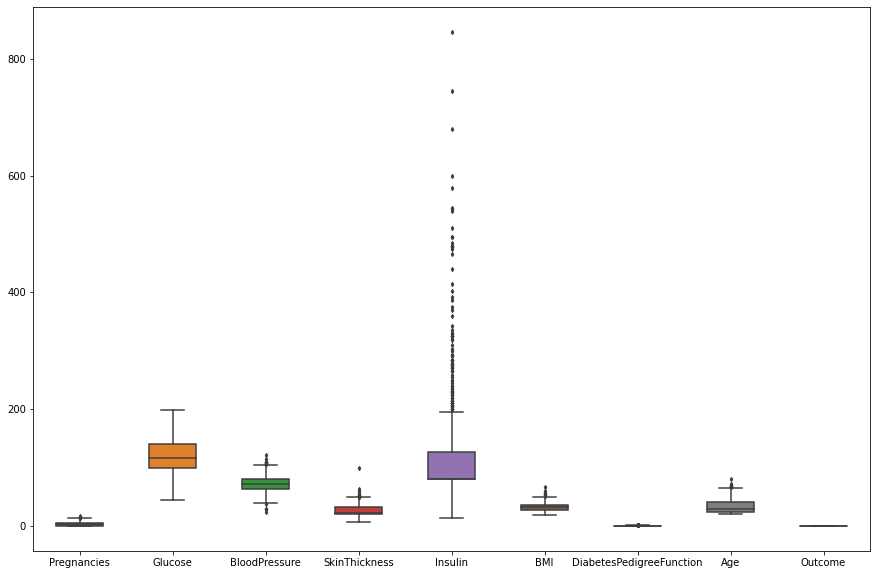

In [17]:
#Check The Outliers
fig, ax = plt.subplots(figsize = (15, 10))
sns.boxplot(data = df, width = 0.5, ax = ax, fliersize = 3)
plt.show()

In [18]:
outlier = df['Pregnancies'].quantile(0.98)
# removing the top 2% df from the pregnancies column
df = df[df['Pregnancies']<outlier]

outlier = df['BMI'].quantile(0.99)
# removing the top 1% df from BMI column
df = df[df['BMI']<outlier]

outlier = df['SkinThickness'].quantile(0.99)
# removing the top 1% df from SkinThickness column
df = df[df['SkinThickness']<outlier]

outlier = df['Insulin'].quantile(0.95)
# removing the top 5% df from Insulin column
df = df[df['Insulin']<outlier]

outlier = df['DiabetesPedigreeFunction'].quantile(0.99)
# removing the top 1% df from DiabetesPedigreeFunction column
df = df[df['DiabetesPedigreeFunction']<outlier]

outlier = df['Age'].quantile(0.99)
# removing the top 1% df from Age column
df = df[df['Age']<outlier]


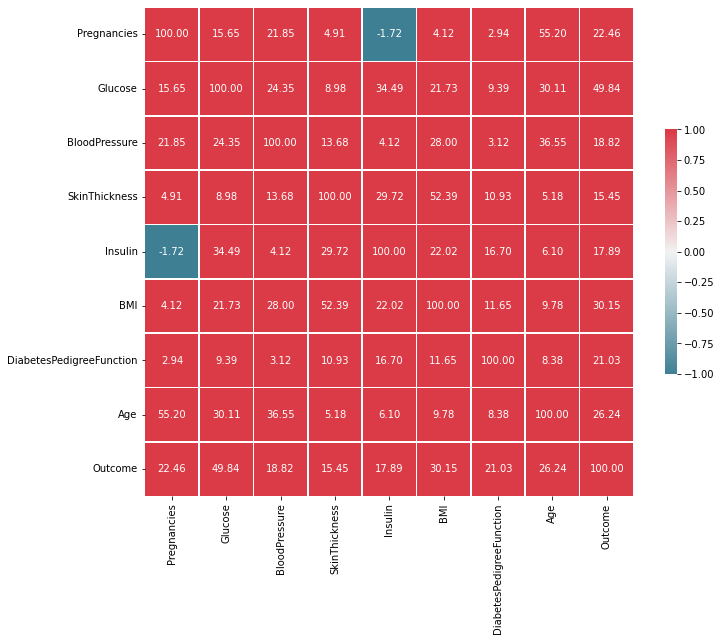

In [24]:
# Calculate the correlation matrix
corr = df.corr()

# Multiply the correlation matrix by 100 to express the values as percentages
corr_percent = corr * 100

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_percent, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt=".2f")

plt.show()

In [25]:
X = df.drop(columns = ['Outcome'])
y = df['Outcome']

In [30]:
# scaling the data 

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(X)

In [31]:
# Split the data into a training set and a holdout set
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.2)

In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Train a random forest and a logistic regression on the training set
base_model_1 = RandomForestClassifier(n_estimators=100)
base_model_2 = LogisticRegression()
base_model_1.fit(X_train, y_train)
base_model_2.fit(X_train, y_train)

LogisticRegression()

In [33]:
# Use the base models to make predictions on the holdout set
predictions_1 = base_model_1.predict_proba(X_holdout)
predictions_2 = base_model_2.predict_proba(X_holdout)

In [35]:
# Stack the predictions from the base models as input features for the meta-model
X_meta = np.concatenate((predictions_1, predictions_2), axis=1)

# Train a meta-model on the stacked predictions
meta_model = LogisticRegression()
meta_model.fit(X_meta, y_holdout)

LogisticRegression()

In [39]:
# Use the meta-model to make predictions on new, unseen data
X_test, y_test = (X_holdout, y_holdout)
predictions_1 = base_model_1.predict_proba(X_test)
predictions_2 = base_model_2.predict_proba(X_test)
X_meta_test = np.concatenate((predictions_1, predictions_2), axis=1)
y_pred = meta_model.predict(X_meta_test)

In [40]:
# Evaluate the performance of the stacked model on the test set
accuracy = sum(y_pred == y_test) / len(y_test)
print(f'Stacked model accuracy: {accuracy:.2f}')

Stacked model accuracy: 0.80


In [41]:
print("Classification Report : \n", classification_report(y_test, y_pred))

Classification Report : 
               precision    recall  f1-score   support

           0       0.83      0.91      0.87        96
           1       0.70      0.54      0.61        39

    accuracy                           0.80       135
   macro avg       0.76      0.72      0.74       135
weighted avg       0.79      0.80      0.79       135

